Classifying Flowers using Transfer Learning in Keras

1- Download a small flower dataset (http://download.tensorflow.org/example_images/flower_photos.tgz). This dataset has 5 classes (Daisy, Dandelion, Rese, Sunflower, and Tulip). Images for each class are stored in its own folder.

2- The images have different dimensions. Resize all of them to 150x150.

3- Split images to 75-25% for training and test. Make sure you have the same distribution of flower types between train and test datasets. 

4- Use a VGG16 model (pre-trained on ImageNet)

5- Remove the top layers (fully connected layers)

6- Add your own fully connected layers (one with 256 nodes using ‘relu’ activation and output layer with 5 nodes and ‘softmax’ activation)

7- First, freeze all layers of VGG16, train (fine-tune) and evaluate the model. You need to pick the right hyper-parameters for your training (try with different ones)

8- Second, unfreeze the last block of VGG16 (block5), re-train and evaluate the model

9- Unfreeze all the layers and try again. 

10- Compare the accuracy you got in both cases . Which one is better and why? 

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from keras import applications
import tensorflow as tf
from tqdm import tqdm
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import random
from shutil import copyfile
import os
import gc
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from keras import backend as K
# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import style
import seaborn as sns
from keras.callbacks import ModelCheckpoint
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

In [3]:
import os
print(os.listdir('../input/flower_photos/flower_photos'))

['tulips', 'roses', 'daisy', 'sunflowers', 'dandelion']


In [4]:
X=[]
y=[]
IMG_SIZE=150
DAISY_DIR='../input/flower_photos/flower_photos/daisy'
SUNFLOWER_DIR='../input/flower_photos/flower_photos/sunflowers'
TULIP_DIR='../input/flower_photos/flower_photos/tulips'
DANDI_DIR='../input/flower_photos/flower_photos/dandelion'
ROSE_DIR='../input/flower_photos/flower_photos/roses'


In [5]:
def assigning_label(img,flower_type):
    return flower_type

In [6]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assigning_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        y.append(str(label))

In [7]:
#create training data
make_train_data('Daisy',DAISY_DIR)
make_train_data('Sunflowers',SUNFLOWER_DIR)
make_train_data('Tulips',TULIP_DIR)
make_train_data('dandelion',DANDI_DIR)
make_train_data('Roses',ROSE_DIR)
print(len(X))

100%|██████████| 641/641 [00:02<00:00, 265.93it/s]

3670


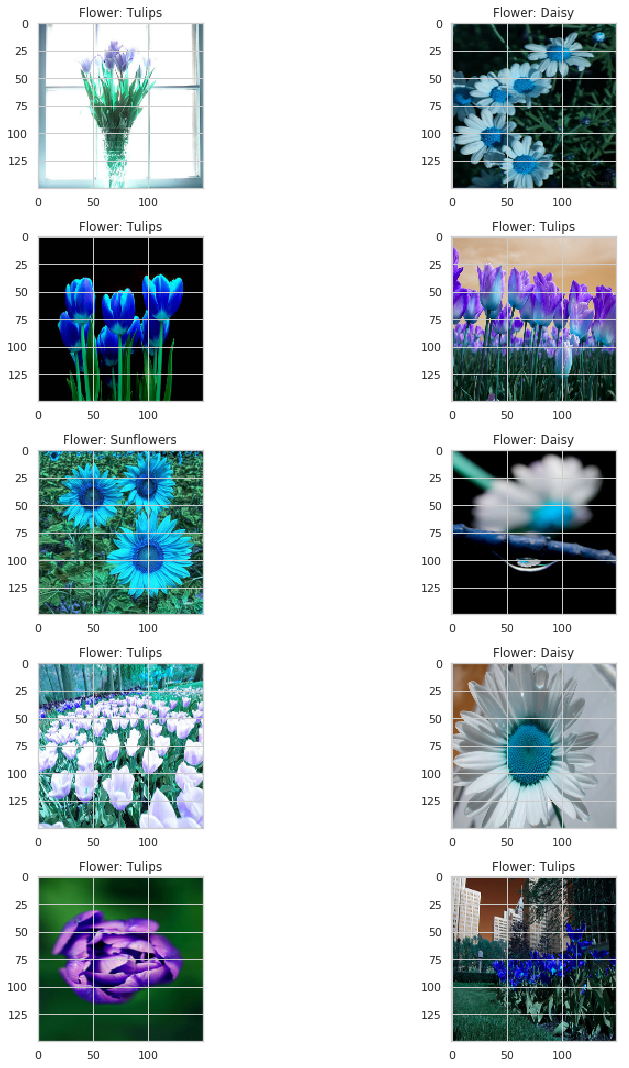

In [8]:
import random as rn
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(y))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+y[l])
        
plt.tight_layout()

In [9]:
from sklearn.preprocessing import LabelEncoder

labelEncoder=LabelEncoder()
y=labelEncoder.fit_transform(y)
y=to_categorical(y,5)
X=np.array(X)
X=X/255

In [10]:
X.shape

(3670, 150, 150, 3)

In [11]:
y.shape

(3670, 5)

In [12]:
X_train_val,X_test,y_train_val,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
X_train,X_val,y_train,y_val=train_test_split(X_train_val,y_train_val,test_size=0.10,random_state=42)

In [13]:
X_train.shape

(2476, 150, 150, 3)

In [14]:
y_train.shape

(2476, 5)

In [15]:
# VGG16 pre-trained model without fully connected layers and with different input dimensions
image_w, image_h = 150,150
model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (image_w, image_h, 3))

58892288/58889256 [==============================] - 2s 0us/step


In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

Model 1 - VGG16  imorted with top layers cut off, all layers then are frozen and new fully connected layers are added.

In [17]:
for layer in model.layers:
    layer.trainable = False
    
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [18]:
def Revised_1_fn(learn_rate=0.01): 
    last = model.output
    x = Flatten()(last)
    x = Dense(256, activation='relu', name='new_fc1', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    preds = Dense(5, activation='softmax')(x)

    Revised_Model_1 = Model(model.input, preds)
    Revised_Model_1.summary()
    Revised_Model_1.compile(loss = "categorical_crossentropy", optimizer = 'Adam', metrics=["accuracy"])
    return Revised_Model_1

Model 2 -  Second, unfreeze the last block of VGG16 (block5)

In [19]:
for layer in model.layers[15:]:
    layer.trainable = True
     
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [20]:
def Revised_2_fn(learn_rate=0.01):
    last = model.output
    x = Flatten()(last)
    x = Dense(256, activation='relu', name='new_fc1', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    preds = Dense(5, activation='softmax')(x)

    Revised_Model_2 = Model(model.input, preds)
    Revised_Model_2.summary()
    Revised_Model_2.compile(loss = "categorical_crossentropy", optimizer = 'Adam', metrics=["accuracy"])
    return Revised_Model_2

Model 3 : Unfreeze all the layers 

In [21]:
for layer in model.layers:
    layer.trainable = True
     
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [22]:
def Revised_3_fn(learn_rate=0.01): 
    last = model.output
    x = Flatten()(last)
    x = Dense(256, activation='relu', name='new_fc1', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    preds = Dense(5, activation='softmax')(x)

    Revised_Model_3 = Model(model.input, preds)
    Revised_Model_3.summary()
    Revised_Model_3.compile(loss = "categorical_crossentropy", optimizer = 'Adam', metrics=["accuracy"])
    return Revised_Model_3

Train, Fine-Tune using Hyper parameters and evaluate the first model.

In [23]:
#using Grid Search and Early stopping
es = EarlyStopping(monitor='val_acc', verbose=2, patience=25)
mc = ModelCheckpoint('./best_model_1.h5', monitor='val_acc', verbose=2, save_best_only=True)

Hyp_Model_1 = KerasClassifier(build_fn=Revised_1_fn)
#You need to pick the right hyper-parameters for your training (try with different ones)

learn_rate = [0.01]
batch_size = [32,75,100]
epochs = [5]

param_grid = dict(batch_size=batch_size, epochs=epochs, learn_rate = learn_rate)
randSearch_1 = GridSearchCV(estimator = Hyp_Model_1, param_grid=param_grid, cv=5)

In [24]:
new_grid_1 = randSearch_1.fit(X_train,y_train, validation_data = (X_val, y_val), verbose=2,callbacks=[es,mc])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________


Epoch 00003: val_acc did not improve from 0.61594
Epoch 4/5
 - 8s - loss: 1.0379 - acc: 0.6123 - val_loss: 1.1075 - val_acc: 0.5652

Epoch 00004: val_acc did not improve from 0.61594
Epoch 5/5
 - 8s - loss: 1.0168 - acc: 0.6073 - val_loss: 1.0328 - val_acc: 0.5833

Epoch 00005: val_acc did not improve from 0.61594
1981/1981 [==============================] - 3s 1ms/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
________________________________


Epoch 00001: val_acc did not improve from 0.69203
Epoch 2/5
 - 8s - loss: 0.8556 - acc: 0.6966 - val_loss: 0.9355 - val_acc: 0.6413

Epoch 00002: val_acc did not improve from 0.69203
Epoch 3/5
 - 8s - loss: 0.7681 - acc: 0.7350 - val_loss: 0.9202 - val_acc: 0.6630

Epoch 00003: val_acc did not improve from 0.69203
Epoch 4/5
 - 8s - loss: 0.7311 - acc: 0.7405 - val_loss: 1.2951 - val_acc: 0.6594

Epoch 00004: val_acc did not improve from 0.69203
Epoch 5/5
 - 8s - loss: 0.7223 - acc: 0.7390 - val_loss: 0.8839 - val_acc: 0.6630

Epoch 00005: val_acc did not improve from 0.69203
1981/1981 [==============================] - 3s 1ms/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
______________________________

Train on 1980 samples, validate on 276 samples
Epoch 1/5
 - 14s - loss: 2.3676 - acc: 0.7157 - val_loss: 1.0065 - val_acc: 0.7536

Epoch 00001: val_acc did not improve from 0.75362
Epoch 2/5
 - 8s - loss: 0.5989 - acc: 0.8313 - val_loss: 0.9075 - val_acc: 0.7428

Epoch 00002: val_acc did not improve from 0.75362
Epoch 3/5
 - 8s - loss: 0.4545 - acc: 0.8667 - val_loss: 0.9606 - val_acc: 0.7464

Epoch 00003: val_acc did not improve from 0.75362
Epoch 4/5
 - 8s - loss: 0.3959 - acc: 0.8879 - val_loss: 1.0233 - val_acc: 0.7717

Epoch 00004: val_acc improved from 0.75362 to 0.77174, saving model to ./best_model_1.h5
Epoch 5/5
 - 8s - loss: 0.3656 - acc: 0.8919 - val_loss: 1.0537 - val_acc: 0.7391

Epoch 00005: val_acc did not improve from 0.77174
1980/1980 [==============================] - 3s 2ms/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0   

Train on 1981 samples, validate on 276 samples
Epoch 1/5
 - 10s - loss: 2.2887 - acc: 0.7688 - val_loss: 1.1341 - val_acc: 0.7681

Epoch 00001: val_acc did not improve from 0.77174
Epoch 2/5
 - 8s - loss: 0.4266 - acc: 0.9197 - val_loss: 1.0990 - val_acc: 0.7355

Epoch 00002: val_acc did not improve from 0.77174
Epoch 3/5
 - 8s - loss: 0.2843 - acc: 0.9419 - val_loss: 1.1012 - val_acc: 0.7681

Epoch 00003: val_acc did not improve from 0.77174
Epoch 4/5
 - 8s - loss: 0.2832 - acc: 0.9354 - val_loss: 0.9582 - val_acc: 0.7645

Epoch 00004: val_acc did not improve from 0.77174
Epoch 5/5
 - 8s - loss: 0.2157 - acc: 0.9531 - val_loss: 1.1433 - val_acc: 0.7246

Epoch 00005: val_acc did not improve from 0.77174
1981/1981 [==============================] - 3s 1ms/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
________________________________

Train on 1981 samples, validate on 276 samples
Epoch 1/5
 - 11s - loss: 2.1623 - acc: 0.8693 - val_loss: 1.3145 - val_acc: 0.7572

Epoch 00001: val_acc did not improve from 0.77174
Epoch 2/5
 - 8s - loss: 0.3874 - acc: 0.9591 - val_loss: 1.2819 - val_acc: 0.7717

Epoch 00002: val_acc improved from 0.77174 to 0.77174, saving model to ./best_model_1.h5
Epoch 3/5
 - 8s - loss: 0.2651 - acc: 0.9667 - val_loss: 1.2905 - val_acc: 0.7609

Epoch 00003: val_acc did not improve from 0.77174
Epoch 4/5
 - 8s - loss: 0.1898 - acc: 0.9783 - val_loss: 1.4619 - val_acc: 0.7645

Epoch 00004: val_acc did not improve from 0.77174
Epoch 5/5
 - 8s - loss: 0.1880 - acc: 0.9712 - val_loss: 1.2916 - val_acc: 0.7754

Epoch 00005: val_acc improved from 0.77174 to 0.77536, saving model to ./best_model_1.h5
1981/1981 [==============================] - 3s 2ms/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)

Train on 1981 samples, validate on 276 samples
Epoch 1/5
 - 14s - loss: 2.6565 - acc: 0.8783 - val_loss: 2.0414 - val_acc: 0.7681

Epoch 00001: val_acc did not improve from 0.78986
Epoch 2/5
 - 9s - loss: 0.5060 - acc: 0.9768 - val_loss: 1.7193 - val_acc: 0.7536

Epoch 00002: val_acc did not improve from 0.78986
Epoch 3/5
 - 8s - loss: 0.3325 - acc: 0.9833 - val_loss: 1.4423 - val_acc: 0.7717

Epoch 00003: val_acc did not improve from 0.78986
Epoch 4/5
 - 8s - loss: 0.2338 - acc: 0.9854 - val_loss: 1.3016 - val_acc: 0.7681

Epoch 00004: val_acc did not improve from 0.78986
Epoch 5/5
 - 9s - loss: 0.2134 - acc: 0.9788 - val_loss: 1.3957 - val_acc: 0.7391

Epoch 00005: val_acc did not improve from 0.78986
1981/1981 [==============================] - 3s 2ms/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
________________________________

Train on 1981 samples, validate on 276 samples
Epoch 1/5
 - 12s - loss: 2.5728 - acc: 0.8980 - val_loss: 2.2050 - val_acc: 0.7645

Epoch 00001: val_acc did not improve from 0.79348
Epoch 2/5
 - 8s - loss: 0.5037 - acc: 0.9743 - val_loss: 1.4900 - val_acc: 0.7645

Epoch 00002: val_acc did not improve from 0.79348
Epoch 3/5
 - 8s - loss: 0.3069 - acc: 0.9864 - val_loss: 1.8798 - val_acc: 0.7464

Epoch 00003: val_acc did not improve from 0.79348
Epoch 4/5
 - 8s - loss: 0.2505 - acc: 0.9838 - val_loss: 1.4326 - val_acc: 0.7428

Epoch 00004: val_acc did not improve from 0.79348
Epoch 5/5
 - 8s - loss: 0.2403 - acc: 0.9702 - val_loss: 1.4602 - val_acc: 0.7428

Epoch 00005: val_acc did not improve from 0.79348
1981/1981 [==============================] - 3s 2ms/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
________________________________

Train on 2476 samples, validate on 276 samples
Epoch 1/5
 - 16s - loss: 2.2093 - acc: 0.9152 - val_loss: 2.1176 - val_acc: 0.7464

Epoch 00001: val_acc did not improve from 0.79348
Epoch 2/5
 - 10s - loss: 0.4783 - acc: 0.9725 - val_loss: 1.6193 - val_acc: 0.7391

Epoch 00002: val_acc did not improve from 0.79348
Epoch 3/5
 - 10s - loss: 0.2604 - acc: 0.9899 - val_loss: 1.6501 - val_acc: 0.7609

Epoch 00003: val_acc did not improve from 0.79348
Epoch 4/5
 - 10s - loss: 0.1702 - acc: 0.9956 - val_loss: 1.6094 - val_acc: 0.7645

Epoch 00004: val_acc did not improve from 0.79348
Epoch 5/5
 - 10s - loss: 0.1330 - acc: 0.9943 - val_loss: 1.4024 - val_acc: 0.8043

Epoch 00005: val_acc improved from 0.79348 to 0.80435, saving model to ./best_model_1.h5


In [25]:
from keras.models import load_model
final_model_1 = load_model('./best_model_1.h5')

In [26]:
# evaluate the model on validation set
val_scores = []
val_scores_1 = final_model_1.evaluate(X_val,y_val, verbose=0)
print("%s: %.2f%%" % (final_model_1.metrics_names[1], val_scores_1[1]*100))
val_scores.append(val_scores_1[1] * 100)

acc: 80.43%


In [27]:
# evaluate the model
finalscores = []
final_scores_1 = final_model_1.evaluate(X_test,y_test, verbose=0)
print("%s: %.2f%%" % (final_model_1.metrics_names[1], final_scores_1[1]*100))
finalscores.append(final_scores_1[1] * 100)

acc: 78.10%


In [28]:
import gc
gc.collect()

272

Train, Fine-Tune using Hyper parameters and evaluate the second model.

In [29]:
#using Grid Search and Early stopping
es = EarlyStopping(monitor='val_acc', verbose=2, patience=5)
mc = ModelCheckpoint('./best_model_2.h5', monitor='val_acc', verbose=2, save_best_only=True)

Hyp_Model_2 = KerasClassifier(build_fn=Revised_2_fn)
#You need to pick the right hyper-parameters for your training (try with different ones)

learn_rate = [0.01]
batch_size = [32,75,100]
epochs = [5]

param_grid = dict(batch_size=batch_size, epochs=epochs, learn_rate = learn_rate)
randSearch_2 = GridSearchCV(estimator = Hyp_Model_2, param_grid=param_grid, cv=5)

In [30]:
new_grid_2 = randSearch_2.fit(X_train,y_train,validation_data = (X_val, y_val), verbose=2,callbacks=[es,mc])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

 - 9s - loss: 0.2588 - acc: 0.9500 - val_loss: 1.2812 - val_acc: 0.7645

Epoch 00005: val_acc did not improve from 0.77536
1981/1981 [==============================] - 3s 2ms/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)       


Epoch 00003: val_acc did not improve from 0.77536
Epoch 4/5
 - 9s - loss: 0.2537 - acc: 0.9546 - val_loss: 1.3881 - val_acc: 0.7391

Epoch 00004: val_acc did not improve from 0.77536
Epoch 5/5
 - 8s - loss: 0.3121 - acc: 0.9384 - val_loss: 1.1863 - val_acc: 0.7645

Epoch 00005: val_acc did not improve from 0.77536
1981/1981 [==============================] - 3s 2ms/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
________________________________

Epoch 2/5
 - 8s - loss: 0.3256 - acc: 0.9813 - val_loss: 1.4969 - val_acc: 0.7645

Epoch 00002: val_acc did not improve from 0.78623
Epoch 3/5
 - 8s - loss: 0.2644 - acc: 0.9722 - val_loss: 1.4025 - val_acc: 0.7717

Epoch 00003: val_acc did not improve from 0.78623
Epoch 4/5
 - 8s - loss: 0.1997 - acc: 0.9808 - val_loss: 1.4964 - val_acc: 0.7645

Epoch 00004: val_acc did not improve from 0.78623
Epoch 5/5
 - 8s - loss: 0.1391 - acc: 0.9924 - val_loss: 1.5669 - val_acc: 0.7609

Epoch 00005: val_acc did not improve from 0.78623
1980/1980 [==============================] - 3s 2ms/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (C

Train on 1981 samples, validate on 276 samples
Epoch 1/5
 - 15s - loss: 2.0835 - acc: 0.9278 - val_loss: 2.1077 - val_acc: 0.7500

Epoch 00001: val_acc did not improve from 0.78623
Epoch 2/5
 - 8s - loss: 0.4298 - acc: 0.9743 - val_loss: 1.4647 - val_acc: 0.7500

Epoch 00002: val_acc did not improve from 0.78623
Epoch 3/5
 - 8s - loss: 0.2206 - acc: 0.9914 - val_loss: 1.3813 - val_acc: 0.7790

Epoch 00003: val_acc did not improve from 0.78623
Epoch 4/5
 - 8s - loss: 0.1717 - acc: 0.9894 - val_loss: 1.4343 - val_acc: 0.7464

Epoch 00004: val_acc did not improve from 0.78623
Epoch 5/5
 - 8s - loss: 0.1670 - acc: 0.9869 - val_loss: 1.3625 - val_acc: 0.7210

Epoch 00005: val_acc did not improve from 0.78623
1981/1981 [==============================] - 3s 1ms/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
________________________________

Train on 1981 samples, validate on 276 samples
Epoch 1/5
 - 16s - loss: 2.0080 - acc: 0.9404 - val_loss: 2.3564 - val_acc: 0.7210

Epoch 00001: val_acc did not improve from 0.78623
Epoch 2/5
 - 8s - loss: 0.3713 - acc: 0.9773 - val_loss: 1.6232 - val_acc: 0.7428

Epoch 00002: val_acc did not improve from 0.78623
Epoch 3/5
 - 8s - loss: 0.2049 - acc: 0.9909 - val_loss: 1.4260 - val_acc: 0.7717

Epoch 00003: val_acc did not improve from 0.78623
Epoch 4/5
 - 8s - loss: 0.1435 - acc: 0.9924 - val_loss: 1.5524 - val_acc: 0.7536

Epoch 00004: val_acc did not improve from 0.78623
Epoch 5/5
 - 8s - loss: 0.1277 - acc: 0.9924 - val_loss: 1.4924 - val_acc: 0.7464

Epoch 00005: val_acc did not improve from 0.78623
1981/1981 [==============================] - 3s 2ms/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
________________________________

Train on 1981 samples, validate on 276 samples
Epoch 1/5
 - 17s - loss: 2.5981 - acc: 0.9213 - val_loss: 2.6943 - val_acc: 0.7790

Epoch 00001: val_acc did not improve from 0.78623
Epoch 2/5
 - 8s - loss: 0.5762 - acc: 0.9763 - val_loss: 2.0919 - val_acc: 0.7464

Epoch 00002: val_acc did not improve from 0.78623
Epoch 3/5
 - 8s - loss: 0.4087 - acc: 0.9738 - val_loss: 1.3883 - val_acc: 0.7862

Epoch 00003: val_acc improved from 0.78623 to 0.78623, saving model to ./best_model_2.h5
Epoch 4/5
 - 9s - loss: 0.2556 - acc: 0.9919 - val_loss: 1.4278 - val_acc: 0.7717

Epoch 00004: val_acc did not improve from 0.78623
Epoch 5/5
 - 8s - loss: 0.1819 - acc: 0.9985 - val_loss: 1.4388 - val_acc: 0.7536

Epoch 00005: val_acc did not improve from 0.78623
1981/1981 [==============================] - 4s 2ms/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0   

Train on 1981 samples, validate on 276 samples
Epoch 1/5
 - 18s - loss: 2.6399 - acc: 0.9182 - val_loss: 2.2352 - val_acc: 0.7717

Epoch 00001: val_acc did not improve from 0.80435
Epoch 2/5
 - 8s - loss: 0.5497 - acc: 0.9849 - val_loss: 1.9150 - val_acc: 0.7609

Epoch 00002: val_acc did not improve from 0.80435
Epoch 3/5
 - 8s - loss: 0.3458 - acc: 0.9909 - val_loss: 1.6891 - val_acc: 0.7826

Epoch 00003: val_acc did not improve from 0.80435
Epoch 4/5
 - 8s - loss: 0.2430 - acc: 0.9960 - val_loss: 1.6851 - val_acc: 0.7572

Epoch 00004: val_acc did not improve from 0.80435
Epoch 5/5
 - 8s - loss: 0.1935 - acc: 0.9939 - val_loss: 1.4531 - val_acc: 0.7826

Epoch 00005: val_acc did not improve from 0.80435
1981/1981 [==============================] - 3s 2ms/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
________________________________

Train on 2476 samples, validate on 276 samples
Epoch 1/5
 - 21s - loss: 2.1791 - acc: 0.9447 - val_loss: 2.2009 - val_acc: 0.7681

Epoch 00001: val_acc did not improve from 0.80435
Epoch 2/5
 - 11s - loss: 0.4160 - acc: 0.9867 - val_loss: 1.8104 - val_acc: 0.7754

Epoch 00002: val_acc did not improve from 0.80435
Epoch 3/5
 - 11s - loss: 0.2771 - acc: 0.9826 - val_loss: 1.6493 - val_acc: 0.7717

Epoch 00003: val_acc did not improve from 0.80435
Epoch 4/5
 - 11s - loss: 0.1818 - acc: 0.9935 - val_loss: 1.6836 - val_acc: 0.7717

Epoch 00004: val_acc did not improve from 0.80435
Epoch 5/5
 - 11s - loss: 0.1373 - acc: 0.9960 - val_loss: 1.8162 - val_acc: 0.7754

Epoch 00005: val_acc did not improve from 0.80435


In [31]:
from keras.models import load_model
final_model_2 = load_model('./best_model_2.h5')

In [32]:
val_scores_2 = final_model_2.evaluate(X_val,y_val, verbose=0)
print("%s: %.2f%%" % (final_model_2.metrics_names[1], val_scores_2[1]*100))
val_scores.append(val_scores_2[1] * 100)

acc: 80.43%


In [33]:
# evaluate the model
final_scores_2 = final_model_2.evaluate(X_test,y_test, verbose=0)
print("%s: %.2f%%" % (final_model_2.metrics_names[1], final_scores_2[1]*100))
finalscores.append(final_scores_2[1] * 100)

acc: 76.80%


In [34]:
import gc
gc.collect()

796

Train, Fine-Tune using Hyper parameters and evaluate the third model.

In [35]:
#using Grid Search and Early stopping

es = EarlyStopping(monitor='val_acc', verbose=2, patience=5)
mc = ModelCheckpoint('./best_model_3.h5', monitor='val_acc', verbose=2, save_best_only=True)

Hyp_Model_3 = KerasClassifier(build_fn=Revised_3_fn)
#You need to pick the right hyper-parameters for your training (try with different ones)

learn_rate = [0.01]
batch_size = [32,75,100]
epochs = [5]

param_grid = dict(batch_size=batch_size, epochs=epochs, learn_rate = learn_rate)
randSearch_3 = GridSearchCV(estimator = Hyp_Model_3, param_grid=param_grid, cv=5)

In [36]:
new_grid_3 = randSearch_3.fit(X_train,y_train,validation_data = (X_val, y_val), verbose=2,callbacks=[es,mc])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

Epoch 5/5
 - 9s - loss: 0.2525 - acc: 0.9611 - val_loss: 1.5828 - val_acc: 0.7101

Epoch 00005: val_acc did not improve from 0.76449
1981/1981 [==============================] - 3s 2ms/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv

Epoch 3/5
 - 9s - loss: 0.1740 - acc: 0.9859 - val_loss: 1.2106 - val_acc: 0.7717

Epoch 00003: val_acc did not improve from 0.78623
Epoch 4/5
 - 9s - loss: 0.2132 - acc: 0.9712 - val_loss: 1.6639 - val_acc: 0.7138

Epoch 00004: val_acc did not improve from 0.78623
Epoch 5/5
 - 9s - loss: 0.2946 - acc: 0.9470 - val_loss: 1.2258 - val_acc: 0.7754

Epoch 00005: val_acc did not improve from 0.78623
1981/1981 [==============================] - 3s 2ms/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (Max


Epoch 00001: val_acc did not improve from 0.81159
Epoch 2/5
 - 8s - loss: 0.2239 - acc: 0.9838 - val_loss: 1.4746 - val_acc: 0.7826

Epoch 00002: val_acc did not improve from 0.81159
Epoch 3/5
 - 8s - loss: 0.1406 - acc: 0.9854 - val_loss: 1.4966 - val_acc: 0.7645

Epoch 00003: val_acc did not improve from 0.81159
Epoch 4/5
 - 8s - loss: 0.1198 - acc: 0.9874 - val_loss: 1.9850 - val_acc: 0.7464

Epoch 00004: val_acc did not improve from 0.81159
Epoch 5/5
 - 8s - loss: 0.2007 - acc: 0.9737 - val_loss: 1.2064 - val_acc: 0.7899

Epoch 00005: val_acc did not improve from 0.81159
1980/1980 [==============================] - 3s 2ms/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
______________________________

Train on 1981 samples, validate on 276 samples
Epoch 1/5
 - 23s - loss: 2.0333 - acc: 0.9369 - val_loss: 2.2031 - val_acc: 0.7283

Epoch 00001: val_acc did not improve from 0.81159
Epoch 2/5
 - 8s - loss: 0.3951 - acc: 0.9753 - val_loss: 1.5188 - val_acc: 0.7572

Epoch 00002: val_acc did not improve from 0.81159
Epoch 3/5
 - 8s - loss: 0.2491 - acc: 0.9859 - val_loss: 1.4407 - val_acc: 0.7790

Epoch 00003: val_acc did not improve from 0.81159
Epoch 4/5
 - 8s - loss: 0.1919 - acc: 0.9869 - val_loss: 1.6379 - val_acc: 0.7428

Epoch 00004: val_acc did not improve from 0.81159
Epoch 5/5
 - 8s - loss: 0.1627 - acc: 0.9879 - val_loss: 1.8011 - val_acc: 0.7572

Epoch 00005: val_acc did not improve from 0.81159
1981/1981 [==============================] - 3s 2ms/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
________________________________

Train on 1981 samples, validate on 276 samples
Epoch 1/5
 - 25s - loss: 2.1254 - acc: 0.8970 - val_loss: 2.2332 - val_acc: 0.7500

Epoch 00001: val_acc did not improve from 0.81159
Epoch 2/5
 - 9s - loss: 0.3409 - acc: 0.9798 - val_loss: 1.8941 - val_acc: 0.7536

Epoch 00002: val_acc did not improve from 0.81159
Epoch 3/5
 - 9s - loss: 0.1940 - acc: 0.9909 - val_loss: 1.6610 - val_acc: 0.7500

Epoch 00003: val_acc did not improve from 0.81159
Epoch 4/5
 - 9s - loss: 0.1447 - acc: 0.9934 - val_loss: 1.9333 - val_acc: 0.7464

Epoch 00004: val_acc did not improve from 0.81159
Epoch 5/5
 - 9s - loss: 0.1310 - acc: 0.9924 - val_loss: 1.5379 - val_acc: 0.7790

Epoch 00005: val_acc did not improve from 0.81159
1981/1981 [==============================] - 4s 2ms/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
________________________________

Train on 1981 samples, validate on 276 samples
Epoch 1/5
 - 26s - loss: 2.4832 - acc: 0.9364 - val_loss: 2.8343 - val_acc: 0.7391

Epoch 00001: val_acc did not improve from 0.81159
Epoch 2/5
 - 8s - loss: 0.4738 - acc: 0.9808 - val_loss: 2.3321 - val_acc: 0.7572

Epoch 00002: val_acc did not improve from 0.81159
Epoch 3/5
 - 8s - loss: 0.3338 - acc: 0.9773 - val_loss: 1.8276 - val_acc: 0.7464

Epoch 00003: val_acc did not improve from 0.81159
Epoch 4/5
 - 8s - loss: 0.2210 - acc: 0.9909 - val_loss: 1.8779 - val_acc: 0.7391

Epoch 00004: val_acc did not improve from 0.81159
Epoch 5/5
 - 8s - loss: 0.1599 - acc: 0.9970 - val_loss: 1.7285 - val_acc: 0.7572

Epoch 00005: val_acc did not improve from 0.81159
1981/1981 [==============================] - 3s 2ms/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
________________________________

Train on 1981 samples, validate on 276 samples
Epoch 1/5
 - 27s - loss: 2.5396 - acc: 0.9157 - val_loss: 2.5908 - val_acc: 0.7464

Epoch 00001: val_acc did not improve from 0.81159
Epoch 2/5
 - 9s - loss: 0.4194 - acc: 0.9924 - val_loss: 2.8562 - val_acc: 0.7283

Epoch 00002: val_acc did not improve from 0.81159
Epoch 3/5
 - 9s - loss: 0.3408 - acc: 0.9833 - val_loss: 1.8828 - val_acc: 0.7428

Epoch 00003: val_acc did not improve from 0.81159
Epoch 4/5
 - 9s - loss: 0.2347 - acc: 0.9889 - val_loss: 1.7561 - val_acc: 0.7500

Epoch 00004: val_acc did not improve from 0.81159
Epoch 5/5
 - 9s - loss: 0.1731 - acc: 0.9980 - val_loss: 1.7116 - val_acc: 0.7464

Epoch 00005: val_acc did not improve from 0.81159
1981/1981 [==============================] - 4s 2ms/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
________________________________

Train on 2476 samples, validate on 276 samples
Epoch 1/5
 - 29s - loss: 2.2196 - acc: 0.9249 - val_loss: 2.3648 - val_acc: 0.7500

Epoch 00001: val_acc did not improve from 0.81159
Epoch 2/5
 - 10s - loss: 0.4034 - acc: 0.9847 - val_loss: 2.0009 - val_acc: 0.7391

Epoch 00002: val_acc did not improve from 0.81159
Epoch 3/5
 - 11s - loss: 0.3178 - acc: 0.9802 - val_loss: 2.1459 - val_acc: 0.7174

Epoch 00003: val_acc did not improve from 0.81159
Epoch 4/5
 - 10s - loss: 0.1911 - acc: 0.9923 - val_loss: 1.6996 - val_acc: 0.7500

Epoch 00004: val_acc did not improve from 0.81159
Epoch 5/5
 - 10s - loss: 0.1480 - acc: 0.9976 - val_loss: 1.7673 - val_acc: 0.7391

Epoch 00005: val_acc did not improve from 0.81159


In [37]:
from keras.models import load_model
final_model_3 = load_model('./best_model_3.h5')

In [38]:
val_scores_3 = final_model_3.evaluate(X_val,y_val, verbose=0)
print("%s: %.2f%%" % (final_model_3.metrics_names[1], val_scores_3[1]*100))
val_scores.append(val_scores_3[1] * 100)

acc: 81.16%


In [39]:
# evaluate the model
final_scores_3 = final_model_3.evaluate(X_test,y_test, verbose=0)
print("%s: %.2f%%" % (final_model_3.metrics_names[1], final_scores_3[1]*100))
finalscores.append(final_scores_3[1] * 100)

acc: 75.60%


In [40]:
import gc
gc.collect()

1058

In [41]:
val_scores

[80.43478243592857, 80.43478260869566, 81.15942046262215]

In [42]:
finalscores

[78.10457515041294, 76.79738563390079, 75.59912852731925]

Text(0.5,1,'Bar Plot of Test Accuracy for all 3 Models')

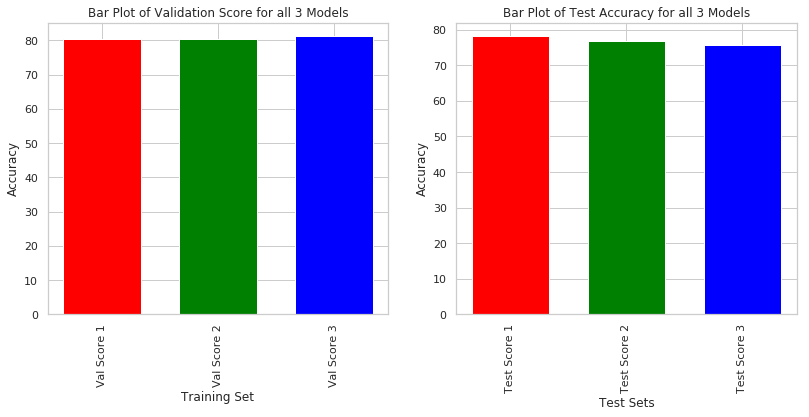

In [43]:
plt.figure(figsize=(25, 5))

plt.subplot(141)
y_hits = val_scores
x_hits = ['Val Score 1' ,'Val Score 2' ,'Val Score 3']
plt.xticks(rotation = 'vertical')
width = 1/1.5
plt.bar(x_hits, y_hits, width, color=['red', 'green', 'blue'])
plt.xlabel('Training Set')
plt.ylabel('Accuracy')
plt.title('Bar Plot of Validation Score for all 3 Models')

plt.subplot(142)
y_hits = finalscores
x_hits = ['Test Score 1','Test Score 2','Test Score 3']
plt.xticks(rotation = 'vertical')
width = 1/1.5
plt.bar(x_hits, y_hits, width, color=['red', 'green', 'blue'])
plt.xlabel('Test Sets')
plt.ylabel('Accuracy')
plt.title('Bar Plot of Test Accuracy for all 3 Models')

Based on the graph above, The model with all frozen layers (model 1) is the Best model. 

Now we predict on Test Data using the best model and Classify the images correctly identified and incorrectly classified

In [48]:
pred=final_model_1.predict(X_test)
pred_digits=np.argmax(pred,axis=1)
act_digits = np.argmax(y_test,axis=1)

In [49]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(act_digits[i]==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not act_digits[i]==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

CORRECTLY CLASSIFIED FLOWER IMAGES

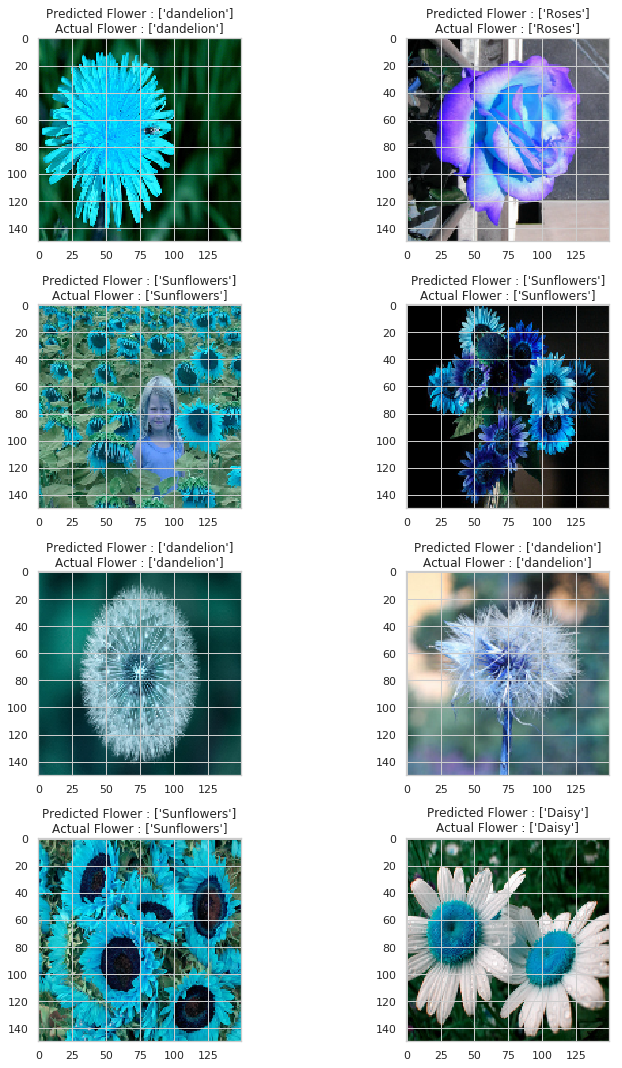

In [50]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(X_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(labelEncoder.inverse_transform([pred_digits[prop_class[count]]])) +"\n"+"Actual Flower : "+str(labelEncoder.inverse_transform([act_digits[prop_class[count]]])))
        plt.tight_layout()
        count+=1

MIS CLASSIFIED FLOWER IMAGES

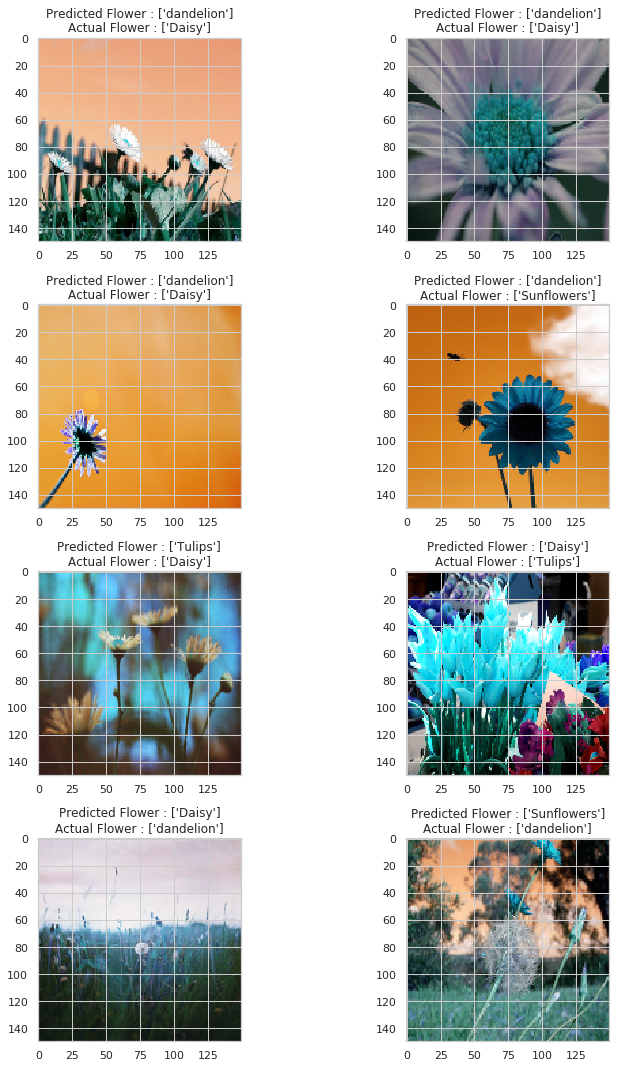

In [51]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(X_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(labelEncoder.inverse_transform([pred_digits[mis_class[count]]])) +"\n"+"Actual Flower : "+str(labelEncoder.inverse_transform([act_digits[mis_class[count]]])))
        plt.tight_layout()
        count+=1

<b>Summary:</b>

Based on the graph above, The model with all frozen layers (model 1) is the Best model in terms of accuracy.

By not updating the weights of most of the network, we are trying to optimize in a subset of the feature space. But the default VGG16 model had been trained on many Image datasets in the past and has been proven to deliver better results. 

As soon as we unfreeze the layers, the model starts becoming trainable and the back propogation is enabled for a few layers in the model. This results a change in the weights for the 5th Block (Model 2) and affect the model accuracy. 

The model 3 eventually turns out to be the worse model with all the layers been trainable. As more trainable layers use certain activation functions are added to neural networks, The gradients of the loss function approaches zero, making the network hard to train. Thus We may need a lot of data to train the 3rd model in order to achieve a better accuracy.